# Language Models
## Homework 2: Embeddings

**Instructor**: Dr. Pavlos Protopapas<br />
**Maximum Score**: 89


## INSTRUCTIONS

- This homework is a notebook. Download and work on it on your local machine or work on it in Colab.

- This homework should be submitted in a group.

- Ensure you and your partners together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit.

- To submit the homework, any one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code.

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**.

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropriate plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

## **Names of the people who worked on this homework**
#### / Brian - Kuan-I Lu/ Danxuan Zhao/ Zixiao Jin/ Zhenghan Fang/ Manho Yeung/ Chule Guan

## **Setup Notebook**

**Imports**

In [1]:
import requests
import urllib
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity


**Verify Setup**

In [2]:
print("tensorflow version", tf.__version__)
#print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.17.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **PART 1 [25 points]: Word2Vec from scratch**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

Word2Vec architecture allows us to get *contextual* representations of word tokens.     

There are several methods to build a word embedding. We will focus on the SGNS architecture.

![](https://drive.google.com/uc?export=view&id=1eyozbhsrzRaKc86SM7LblgzVMZKAW8Pe)

In this problem, you are asked to build and analyze a Word2Vec architecture trained on Wikipedia articles.

</div>

### **PART 1: Questions**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

    
**1.1 [5 points] Model Processing**
<br />
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
**1.1.1** - Get the data    

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from Wikipedia pages. More details can be found [here](https://paperswithcode.com/sota/language-modelling-on-text8)
    It is usually used to quickly train, or test language models.

- Split the data by whitespace and print the first 10 words to check if has been correctly loaded.

    **NOTE:** For this part of the homework, all words will be in their lowercase for simplicity of analysis
<br />    

**1.1.2** - Build the dataset

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`    
<br />
    
**1.1.3** - Build skipgrams with negative samples
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
Skip-gram Sampling table
A large dataset means a larger vocabulary with a higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank-based probabilistic sampling table and pass it to skipgrams function.    
<br />
    
**1.1.4** - What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
<br /><br />
    
</details>
    
**1.2 [8 points] Building a Word2Vec model**
<br />
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
Build a word2vec model architecture based on the schematic below.


![](https://drive.google.com/uc?export=view&id=1fBTpoBoG5RZIPTtdogZt37Bw3oUb7tuT)
  
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer.
- Sufficiently train the model.    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load)    
<br />

</details>
    
    
**1.3 [7 points] Post-training analysis**

<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
This segment involves some simple analysis of your trained embeddings.
<br /><br />
    
    
**1.3.1** - Vector Algebra on Embeddings

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in the session 3 exercise.

**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word. Use this function to find the words most similar to `king`.
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
    
<br />
    
**1.3.2** - Visualizing Embeddings

Find the embeddings for the words:
1. 'January'
2. 'February'
3. 'March'
4. 'April'
    
Find the `cosine_similarity()` of 'january' with each of 'february`, 'march', 'april' (which should be high values).
    
Save your trained weights. Recreate the network you have created above and initialize it with random weights. Compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions:
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
Bonus points for using creative means to demonstrate how the embeddings change after training.

Here is a [video](https://youtu.be/VDl_iA8m8u0) of a sample demonstration. We used a custom callback to get embeddings during training.  
        

<br />
    
**1.3.3** - Embedding and Context Matrix
    
    
**1.3.3.1** Investigate the relation between the Embedding & Context matrix. Again use the `cosine_similarity()` function to find the average value across all the words in the embedding and context matrix, i.e:
  - For the word 'dog', find the embedding value, and context value. <br>
  - Calculate the `cosine_similarity()` between the two <br>
  - Repeat the same for every word in the vocabulary and calculate the average value of the `cosine_similarity()`
<br />

**1.3.3.2** Answer the following question and explain:

**Question:** The embedding and context matrices should be identical.
<br /><br />
    
 </details>

**1.4 [5 points] Learning phrases**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>

As per the original paper by [Mikolov et al](https://arxiv.org/abs/1301.3781) many phrases have a meaning that is not a simple composition of the meanings of their individual words.
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occurring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
<br /><br />

    
**1.4.1** - Find 100 most common bi-grams

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. E.g., if `prime, minister` is a commonly occurring pair, replace `... prime minister ...' in the original corpus with a single entity `prime_minister`. Do this for all 100 pairs.
<br /><br />
    
**1.4.2** - Retrain word2vec
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.

Write a function `most_dissimilar()`, similar to the `most_similar()` function, however this finds the top-n words which are **most dissimilar** to the given word.
Use this function defined above to find the entities most dissimilar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000)).
<br /> <br />
</div>

### **PART 1: Solutions**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
#### **1.1 [5 points] Model processing**

**1.1.1** - Get the data  

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from Wikipedia pages. More details can be found [here](https://paperswithcode.com/sota/language-modelling-on-text8)
    It is usually used to quickly train, or test language models.
    
- Split the data by whitespace and print the first 10 words to check if has been correctly loaded.

    **NOTE:** For this part of the homework, all words will be in their lowercase for simplicity of analysis   
    </div>

In [3]:
# Helper code to read the data

# Download
urllib.request.urlretrieve("https://github.com/dlops-io/datasets/releases/download/v1.0/text8.zip", "text8.zip")

# Unzip and read data
filename = 'text8.zip'
with zipfile.ZipFile(filename) as f:
    vocabulary = tf.compat.as_str(f.read(f.namelist()[0])).split()
vocabulary[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.2** - Build the dataset  

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`
    
</div>

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
   # Your code here
    tokenizer = Tokenizer(num_words=n_words, oov_token='<unk>')


    tokenizer.fit_on_texts(words)
    data = tokenizer.texts_to_sequences(words)
    data = [token[0] for token in data]
    count = tokenizer.word_counts
    dictionary = tokenizer.word_index
    reverse_dictionary = tokenizer.index_word

    return data, count, dictionary, reverse_dictionary

In [6]:
vocab_size = 20000
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocab_size)


In [8]:
reversed_data = [reverse_dictionary[token] for token in data[:10]]

print(vocabulary[:10])
print(data[:10])
print(reversed_data)

del vocabulary  # Hint to reduce memory.

NameError: name 'vocabulary' is not defined

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.3** - Build skipgrams with negative samples
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
Skip-gram Sampling table
A large dataset means a larger vocabulary with a higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank-based probabilistic sampling table and pass it to skipgrams function.    

</div>

In [9]:
# Your code here
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing.sequence import make_sampling_table

sampling_table = make_sampling_table(vocab_size) # Create sampling table to downsample higher frequency words

window_size = 3 # Define a window size of 3
couples, labels = skipgrams(sequence= data, vocabulary_size= vocab_size, window_size= window_size, negative_samples= 1, sampling_table= sampling_table)

# Separate the target,context pairs as word_target, word_context
word_center = [pair[0] for pair in couples]
word_context = [pair[1] for pair in couples]
print(couples[:10], labels[:10])



[[18711, 5594], [17392, 517], [5037, 15152], [4908, 824], [634, 186], [20, 48], [18848, 300], [2823, 14709], [2478, 7874], [903, 23]] [0, 1, 0, 1, 1, 1, 1, 0, 0, 1]


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.4** - What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
    
With the use of a sampling table, we can avoid sampling too much from some of the high-frequency words that carrys less significance(such as the, is, on). This in turns make our skipgrams sample more from more meaningful words compare to if we didn't use the sampling model.
</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.2 [8 points]** **Building a word2vec model**

Build a word2vec model architecture based on the schematic below.


![](https://drive.google.com/uc?export=view&id=1fBTpoBoG5RZIPTtdogZt37Bw3oUb7tuT)
  
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer.
- Sufficiently train the model.    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load)    
    
</div>

In [10]:
# Your code here
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, Dot, Activation
from tensorflow.keras.optimizers import Adam

embedding_dim = 16 # Define the embedding dimension

# Build model for target words
word_input = Input(shape=(1,))
word_embedding = Embedding(vocab_size, embedding_dim, name="word_embedding")(word_input)
word_embedding = Reshape((embedding_dim,))(word_embedding)

# Build model for context words
context_input = Input(shape=(1,))
context_embedding = Embedding(vocab_size, embedding_dim, name="context_embedding")(context_input)
context_embedding = Reshape((embedding_dim,))(context_embedding)

# Calculate the dot product and apply the sigmoid to the dot product
dot_product = Dot(axes=1)([word_embedding, context_embedding])
dot_product = Dense(1,activation="sigmoid")(dot_product) # Output a scalar


# Build the w2v_model with [word_model.input, context_model.input] as input and sigmoid_dot_product as output
w2v_model = Model(inputs=[word_input, context_input], outputs=dot_product)

# Compile the model
learning_rate = 0.0005
optimizer = Adam(learning_rate = learning_rate)
w2v_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # Choose binary crossentropy as loss and adam as optimizer

# Look at the summary of the model
w2v_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ word_embedding            │ (None, 1, 16)          │        320,000 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ context_embedding         │ (None, 1, 16)          │        320,000 │ input_layer_1[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 16)             │              0 │ word_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 16)             │              0 │ context_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │              2 │ dot[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 640,002 (2.44 MB)

 Trainable params: 640,002 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# create the training dataset with word_center, word_context and labels
couples = np.array(couples)
labels = np.array(labels)

batch_size = 512

dataset = tf.data.Dataset.from_tensor_slices(((couples[:,0], couples[:,1]), labels))
dataset = dataset.shuffle(buffer_size=len(couples))
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [12]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 15

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

w2v_model.fit(dataset, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 358s 3ms/step - accuracy: 0.8242 - loss: 0.3850
Epoch 2/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 353s 3ms/step - accuracy: 0.8518 - loss: 0.3396
Epoch 3/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 399s 3ms/step - accuracy: 0.8604 - loss: 0.3232
Epoch 4/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 380s 3ms/step - accuracy: 0.8659 - loss: 0.3115
Epoch 5/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 382s 3ms/step - accuracy: 0.8694 - loss: 0.3036
Epoch 6/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 378s 3ms/step - accuracy: 0.8718 - loss: 0.2986
Epoch 7/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 379s 3ms/step - accuracy: 0.8733 - loss: 0.2952
Epoch 8/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 377s 3ms/step - accuracy: 0.8747 - loss: 0.2924
Epoch 9/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 380s 3ms/step - accuracy: 0.8756 - loss: 0.2903
Epoch 10/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 382s 3ms/step - accuracy: 0.8764 - loss: 0.2886
Epoch 11/15
82975/82975 ━━━━━━━━━━━━━━━━━━━━ 377s 3ms/step - accuracy: 0.8772 -

In [18]:
# Save the trained weights
w2v_model.save_weights('w2v_model.weights.h5')


In [19]:
# Load the trained weights
w2v_model.load_weights('w2v_model.weights.h5')

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.3 [7 points] Post-training analysis**
    
This segment involves some simple analysis of your trained embeddings.


    
**1.3.1** - Vector Algebra on Embeddings

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in the session 3 exercise.

**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word. Use this function to find the words most similar to `king`.
    <br />
    <br />
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
    
<br />
    
</div>

In [13]:
# Your code here

# Find the token of the words
king = dictionary['king']
male = dictionary['male']
female = dictionary['female']
queen = dictionary['queen']

# Find the embedding for the words
embedding_layer = w2v_model.get_layer('word_embedding')
embedding_weights = embedding_layer.get_weights()[0]

king_embedding = embedding_weights[king]
male_embedding = embedding_weights[male]
female_embedding = embedding_weights[female]
queen_embedding = embedding_weights[queen]

# Define the custom vector v
v = king_embedding - male_embedding + female_embedding

# Find the cosine_similarity of v and queen_embedding
print("The cosine similarity between v and the word queen is ", cosine_similarity([v], [queen_embedding]))

The cosine similarity between v and the word queen is  [[0.9084299]]


In [20]:
# Find the most similar words with king
def most_similar(target_word, n_most = 10):

  temp = {}

  for idx in range(1, len(embedding_weights)):
    temp[reverse_dictionary[idx]] = cosine_similarity([embedding_weights[dictionary[target_word]]], [embedding_weights[idx]])

  temp = sorted(temp.items(), key=lambda x: x[1], reverse=True)
  return temp[:n_most]

king_most_similar = most_similar('king')

print('Top 10 most similar words to king: ', king_most_similar)

Top 10 most similar words to king:  [('king', array([[0.99999994]], dtype=float32)), ('vii', array([[0.9589078]], dtype=float32)), ('pretender', array([[0.9576765]], dtype=float32)), ('kazimierz', array([[0.9575622]], dtype=float32)), ('aquitaine', array([[0.9574959]], dtype=float32)), ('eldest', array([[0.9552106]], dtype=float32)), ('consort', array([[0.9549319]], dtype=float32)), ('jehoram', array([[0.9536752]], dtype=float32)), ('prince', array([[0.95176154]], dtype=float32)), ('empress', array([[0.9517124]], dtype=float32))]


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

    
**1.3.2** - Visualizing Embeddings

Find the embeddings for the words:
1. 'January'
2. 'February'
3. 'March'
4. 'April'
    
Find the `cosine_similarity()` of 'january' with each of 'february`, 'march', 'april' (which should be high values).
    
Save your trained weights. Recreate the network you have created above and initialize it with random weights. Compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions:
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
Bonus points for using creative means to demonstrate how the embeddings change after training.

Here is a [video](https://youtu.be/VDl_iA8m8u0) of a sample demonstration. We used a custom callback to get embeddings during training.  
            
</div>

In [21]:
# Your code here

# Find the token of the words
january = dictionary['january']
february = dictionary['february']
march = dictionary['march']
april = dictionary['april']

# Find the embedding of the words
embedding_layer = w2v_model.get_layer('word_embedding')
embedding_weights = embedding_layer.get_weights()[0]

january_embedding = embedding_weights[january]
febuary_embedding = embedding_weights[february]
march_embedding = embedding_weights[march]
april_embedding = embedding_weights[april]

# Find and print the cosine similarity
print("The cosine similarity between january and febuary is ", cosine_similarity([january_embedding], [febuary_embedding]))
print("The cosine similarity between january and march is ", cosine_similarity([january_embedding], [march_embedding]))
print("The cosine similarity between january and april is ", cosine_similarity([january_embedding], [april_embedding]))

The cosine similarity between january and febuary is  [[0.9613031]]
The cosine similarity between january and march is  [[0.9486748]]
The cosine similarity between january and april is  [[0.9802075]]


In [22]:
# Rebuild the model with random weights

# Build model for target words
word_input = Input(shape=(1,))
word_embedding = Embedding(vocab_size, embedding_dim, name="word_embedding")(word_input)
word_embedding = Reshape((embedding_dim,))(word_embedding)

# Build model for context words
context_input = Input(shape=(1,))
context_embedding = Embedding(vocab_size, embedding_dim, name="context_embedding")(context_input)
context_embedding = Reshape((embedding_dim,))(context_embedding)

# Calculate the dot product and apply the sigmoid to the dot product
dot_product = Dot(axes=1)([word_embedding, context_embedding])
dot_product = Dense(1,activation="sigmoid")(dot_product) # Output a scalar


# Build the w2v_model with [word_model.input, context_model.input] as input and sigmoid_dot_product as output
w2v_model = Model(inputs=[word_input, context_input], outputs=dot_product)

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate = learning_rate)
w2v_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [23]:
# Get the weights of the model
embedding_layer_rd = w2v_model.get_layer('word_embedding')
embedding_weights_rd = embedding_layer_rd.get_weights()[0]

# Find the embedding of the words
january_embedding_rd = embedding_weights_rd[january]
febuary_embedding_rd = embedding_weights_rd[february]
march_embedding_rd = embedding_weights_rd[march]
april_embedding_rd = embedding_weights_rd[april]

# Find and print the cosine similarity
print("The cosine similarity between january and febuary with random weights is ", cosine_similarity([january_embedding_rd], [febuary_embedding_rd]))
print("The cosine similarity between january and march with random weights is ", cosine_similarity([january_embedding_rd], [march_embedding_rd]))
print("The cosine similarity between january and april with random weights is ", cosine_similarity([january_embedding_rd], [april_embedding_rd]))

The cosine similarity between january and febuary with random weights is  [[0.3913076]]
The cosine similarity between january and march with random weights is  [[0.2785447]]
The cosine similarity between january and april with random weights is  [[0.08964897]]


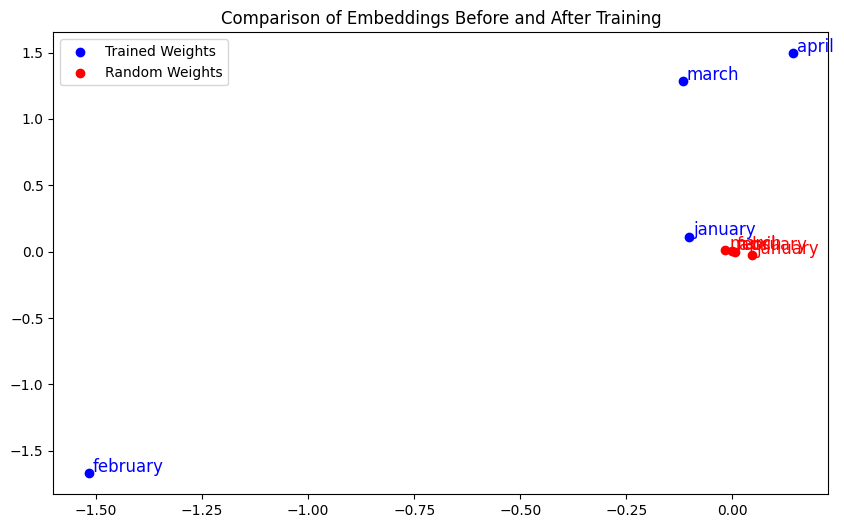

In [26]:
# Initialize the word list
words = ['january', 'february', 'march', 'april']

# Visualize the embeddings before and after training
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Reduce dimensions for both sets of embeddings
reduced_embeddings = pca.fit_transform(embedding_weights)
reduced_embeddings_rd = pca.fit_transform(embedding_weights_rd)

plt.figure(figsize=(10, 6))

# Plot embeddings after training
for i, label in enumerate(words):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, color='blue', label='Trained Weights' if i == 0 else "")
    plt.text(x + 0.01, y + 0.01, label, fontsize=12, color='blue')

# Plot embeddings with random weights (plot B)
for i, label in enumerate(words):
    x, y = reduced_embeddings_rd[i]
    plt.scatter(x, y, color='red', label='Random Weights' if i == 0 else "")
    plt.text(x + 0.01, y + 0.01, label, fontsize=12, color='red')

plt.title('Comparison of Embeddings Before and After Training')
plt.legend()
plt.show()

<ipython-input-25-9dc7bf5ed4d0>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['january', 'febuary', 'march', 'april'])


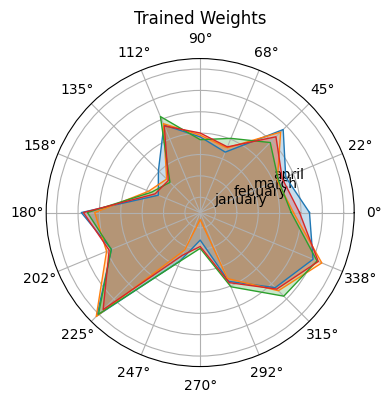

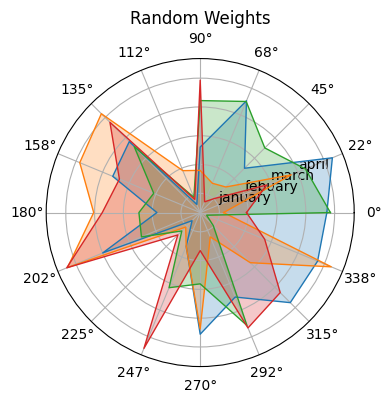

In [25]:
# Define data and function for radar plots

embeddings = np.array([january_embedding, febuary_embedding, march_embedding, april_embedding])
embeddings_rd = np.array([january_embedding_rd, febuary_embedding_rd, march_embedding_rd, april_embedding_rd])

def plot_radar(embeddings, title):
    num_vars = len(embeddings[0])

    # Calculate angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

    for embedding in embeddings:
        values = embedding.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels(['january', 'febuary', 'march', 'april'])
    ax.set_xticks(angles[:-1])

    plt.title(title)
    plt.show()

# Graph radar plots
plot_radar(embeddings, 'Trained Weights')
plot_radar(embeddings_rd, 'Random Weights')

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.3.3** - Embedding and Context Matrix
    
    
**1.3.3.1** Investigate the relation between the Embedding & Context matrix. Again use the `cosine_similarity()` function to find the average value across all the words in the embedding and context matrix, i.e:
  - For the word 'dog', find the embedding value, and context value. <br>
  - Calculate the `cosine_similarity()` between the two <br>
  - Repeat the same for every word in the vocabulary and calculate the average value of the `cosine_similarity()`
<br />

**1.3.3.2** Answer the following question and explain:

**Question:** The embedding and context matrices should be identical.
<br />
    
</div>

In [27]:
# Your code here
# load the trained weights
w2v_model.load_weights('w2v_model.weights.h5')

# get the embedding and context layers
embedding_layer = w2v_model.get_layer('word_embedding')
context_layer = w2v_model.get_layer('context_embedding')

# get the weights
embedding_weights = embedding_layer.get_weights()[0]
context_weights = context_layer.get_weights()[0]

# calculate the consine_similarity between the two for all words
relation = []

for index in range(len(embedding_weights)):
    relation.append(cosine_similarity([embedding_weights[index]], [context_weights[index]]))

print("Average cosine similarity across all the words in the embedding and context matrix: ", np.mean(relation))


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Average cosine similarity across all the words in the embedding and context matrix:  0.29617494


**Answer:** No, the embedding and context matrices are not idential, because they carry different purposes. The function of embedding matrix is to capture the overall semantic meaning, while the purporse of context matrix is to capture the relationship between the words and their contexts, representing how it relates to other words.

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.4 [5 points] Learning phrases**
    
As per the original paper by [Mikolov et al](https://arxiv.org/abs/1301.3781) many phrases have a meaning that is not a simple composition of the meanings of their individual words.
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occurring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
    
</div>

**1.4.1** - Find 100 most common bi-grams

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. E.g., if `prime, minister` is a commonly occurring pair, replace `... prime minister ...' in the original corpus with a single entity `prime_minister`. Do this for all 100 pairs.

In [28]:
# Get the training data again
# Download and unzip
urllib.request.urlretrieve("https://github.com/dlops-io/datasets/releases/download/v1.0/text8.zip", "text8.zip")

filename = 'text8.zip'
with zipfile.ZipFile(filename) as f:
# Read the data into a list of strings.
    super_text = tf.compat.as_str(f.read(f.namelist()[0]))

In [29]:
# Fill in to complete this function
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""

    tokenizer = Tokenizer(num_words=n_words, oov_token='<unk>', filters='')

    tokenizer.fit_on_texts(words)
    data = tokenizer.texts_to_sequences(words)
    data = [token[0] for token in data]
    count = tokenizer.word_counts
    dictionary = tokenizer.word_index
    reverse_dictionary = tokenizer.index_word

    return data, count, dictionary, reverse_dictionary

In [30]:
# Make sure to use lower case and split as before
corpus = super_text.lower().split()
data, count, dictionary, reverse_dictionary = build_dataset(corpus,6000)

In [35]:
# Your code here
# Create a dictionary of bigrams and counts
bigrams = {}

for i in range(len(data) - 1):
    bigram = (data[i], data[i + 1])
    if bigram in bigrams:
        bigrams[bigram] += 1
    else:
        bigrams[bigram] = 1

# Calculate bigram scores
bigram_score = {}

for (w1, w2), counts in list(bigrams.items()):
  if counts > 500:      # Make sure the bigram is a commonly used word
    if reverse_dictionary[w1] in count and reverse_dictionary[w2] in count:
      bigram_score[(w1, w2)] = counts / (count[reverse_dictionary[w1]] * count[reverse_dictionary[w2]])

# Select the top 100 highest scoring bigrams
top_100_bigrams = sorted(bigram_score.items(), key=lambda x: x[1], reverse=True)[:100]


In [36]:
# Visualize top_10_bigrams
top_10_bigrams = top_100_bigrams[:10]
top_10_bigrams = [reverse_dictionary[bigram[0]]+" "+reverse_dictionary[bigram[1]]  for bigram, score in top_10_bigrams]

print('Top 10 bigrams:', top_10_bigrams)

Top 10 bigrams: ['hip hop', 'los angeles', 'hong kong', 'mac os', 'http www', 'prize laureate', 'san francisco', 'nobel prize', 'prime minister', 'middle ages']


In [37]:
# replace the common bigrams in the corpus
new_corpus = []
i = 0
while i < len(corpus):
    if i < len(corpus) - 1 and (dictionary[corpus[i]], dictionary[corpus[i + 1]]) in [bigram for bigram, score in top_100_bigrams]:
        new_corpus.append(corpus[i]+'_'+corpus[i + 1])
        i += 2
    else:
        new_corpus.append(corpus[i])
        i += 1

In [38]:
# Delete courpus to free up space
del corpus

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.4.2** - Retrain word2vec   
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.

Write a function `most_dissimilar()`, similar to the `most_similar()` function, however this finds the top-n words which are **most dissimilar** to the given word.
Use this function defined above to find the entities most dissimilar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000).
<br />

</div>

In [39]:
# Your code here
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing.sequence import make_sampling_table

# Build the dataset
vocab_size = 10000

data, count, dictionary, reverse_dictionary = build_dataset(new_corpus,vocab_size)

# Create skipgrams
sampling_table = make_sampling_table(vocab_size) # Create sampling table to downsample higher frequency words

window_size = 3 # Define a window size of 3
couples, labels = skipgrams(sequence= data, vocabulary_size= vocab_size, window_size= window_size, negative_samples= 1, sampling_table= sampling_table)

# Separate the target,context pairs as word_target, word_context
word_center = [pair[0] for pair in couples]
word_context = [pair[1] for pair in couples]



In [40]:
# Redefine the model, same code as 1.2
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, Dot, Activation
from tensorflow.keras.optimizers import Adam

embedding_dim = 32 # Define the embedding dimension

# Build model for target words
word_input = Input(shape=(1,))
word_embedding = Embedding(vocab_size, embedding_dim, name="word_embedding")(word_input)
word_embedding = Reshape((embedding_dim,))(word_embedding)

# Build model for context words
context_input = Input(shape=(1,))
context_embedding = Embedding(vocab_size, embedding_dim, name="context_embedding")(context_input)
context_embedding = Reshape((embedding_dim,))(context_embedding)

# Calculate the dot product and apply the sigmoid to the dot product
dot_product = Dot(axes=1)([word_embedding, context_embedding])
dot_product = Dense(1,activation="sigmoid")(dot_product) # Output a scalar


# Build the w2v_model with [word_model.input, context_model.input] as input and sigmoid_dot_product as output
w2v_model = Model(inputs=[word_input, context_input], outputs=dot_product)

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate = learning_rate)
w2v_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # Choose binary crossentropy as loss and adam as optimizer

# Create the training dataset with word_center, word_context and labels
couples = np.array(couples)
labels = np.array(labels)

batch_size = 1024

dataset = tf.data.Dataset.from_tensor_slices(((couples[:,0], couples[:,1]), labels))
dataset = dataset.shuffle(buffer_size=len(couples))
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
# Retrain our word2vec
num_epochs = 10

w2v_model.fit(dataset, epochs=num_epochs, batch_size=batch_size)


Epoch 1/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 270s 6ms/step - accuracy: 0.8695 - loss: 0.3011
Epoch 2/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 271s 6ms/step - accuracy: 0.8706 - loss: 0.2989
Epoch 3/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 297s 6ms/step - accuracy: 0.8713 - loss: 0.2972
Epoch 4/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.8716 - loss: 0.2964
Epoch 5/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 301s 6ms/step - accuracy: 0.8721 - loss: 0.2954
Epoch 6/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 302s 6ms/step - accuracy: 0.8724 - loss: 0.2949
Epoch 7/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 299s 6ms/step - accuracy: 0.8727 - loss: 0.2942
Epoch 8/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 296s 6ms/step - accuracy: 0.8728 - loss: 0.2939
Epoch 9/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 302s 6ms/step - accuracy: 0.8729 - loss: 0.2935
Epoch 10/10
32987/32987 ━━━━━━━━━━━━━━━━━━━━ 301s 6ms/step - accuracy: 0.8731 - loss: 0.2931


In [ ]:
# Save the weights
w2v_model.save_weights('w2v_model_with_phrase.weights.h5')

In [41]:
# Load the weights
w2v_model.load_weights('w2v_model_with_phrase.weights.h5')

In [42]:
# Extract the embedding weights
embedding_layer = w2v_model.get_layer('word_embedding')
embedding_weights = embedding_layer.get_weights()[0]

In [43]:
# Define the most dissimilar function
def most_dissimilar(target_word, n_most = 10):

  temp = {}

  for idx in range(1, len(embedding_weights)):
    temp[reverse_dictionary[idx]] = cosine_similarity([embedding_weights[dictionary[target_word]]], [embedding_weights[idx]])

  temp = sorted(temp.items(), key=lambda x: x[1], reverse=False)
  return temp[:n_most]

united_kingdom_most_dissimilar = most_dissimilar('united_kingdom')

print('Top 10 most dissimilar words to united_kingdom: ', united_kingdom_most_dissimilar)


Top 10 most dissimilar words to united_kingdom:  [('prophetic', array([[0.01756217]], dtype=float32)), ('sensory', array([[0.04132243]], dtype=float32)), ('meter', array([[0.04337403]], dtype=float32)), ('illusion', array([[0.04348914]], dtype=float32)), ('meditation', array([[0.04420625]], dtype=float32)), ('mishnah', array([[0.04783754]], dtype=float32)), ('bottle', array([[0.04944154]], dtype=float32)), ('subjective', array([[0.04985476]], dtype=float32)), ('passages', array([[0.05053059]], dtype=float32)), ('illustrations', array([[0.05118572]], dtype=float32))]


In [44]:
# Find the cosine similarities
# Get the embeddings

united_kingdom_embedding = embedding_weights[dictionary['united_kingdom']]
united_embedding = embedding_weights[dictionary['united']]
kingdom_embedding = embedding_weights[dictionary['kingdom']]
united_and_kingdom_embedding = united_embedding + kingdom_embedding

print("The cosine similarity of united_kingdom and united: ", cosine_similarity([united_kingdom_embedding], [united_embedding]))
print("The cosine similarity of united_kingdom and kingdom: ", cosine_similarity([united_kingdom_embedding], [kingdom_embedding]))
print("The cosine similarity of united_kingdom and united + kingdom: ", cosine_similarity([united_kingdom_embedding], [united_and_kingdom_embedding]))

The cosine similarity of united_kingdom and united:  [[0.61632997]]
The cosine similarity of united_kingdom and kingdom:  [[0.65125656]]
The cosine similarity of united_kingdom and united + kingdom:  [[0.70881784]]


## **PART 2 [64 points]: IMDB Sentiment Analysis using ELMo**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
   
Sentiment analysis, also known as opinion mining or emotion AI, is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.
    
For this part of the homework, we will be using the IMDB dataset, which is publicly available [here](http://ai.stanford.edu/~amaas/data/sentiment/).    

This represents a "many-to-one" problem, with the output classified as a `positive` or `negative` sentiment, depending on the words used in the review.
    
    
In the first part of this section, you are expected to build a language model to train a basic ELMo.
    
Although the original ELMo implementation uses *Character Embeddings*, for the sake of this homework, we will use word embeddings instead.
    
Read more about the ELMo paper [here](https://arxiv.org/pdf/1802.05365.pdf).

In the second part of this subsection, you will use the generated ELMo embeddings in a deep-learning model to perform sentiment analysis using the IMDB dataset.
    
You will compare its performance, with a baseline model without any trained embeddings, and another model which directly uses the `word2vec` embeddings.

<br />
    </div>

### **PART 2: Questions**    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

 **2.1 [15 points] Preprocess the dataset**
<br />

<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occurring words.
- Limit the largest review to a maximum of 200 words only.
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which have to be corrected. A helper code is provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end-of-sentence token \<\/s>.

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"
<br />

**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
**NOTE**: To access the pre-trained embeddings, [gensim](https://pypi.org/project/gensim/) library can be used.

Check if the embeddings for the start token (\<s\>) and end token (\</s\>) are present in the loaded `word2vec` embeddings.

Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors if they are not present.

Create an `embedding_matrix` that will consist of the words present in word2vec. It will be a matrix of dimension `num_words X embedding_dim` `(5000 X 300)` including the addition of start and end tokens.
<br /><br />
**2.1.3** Prepare data for model training:

- Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
```

- Split the data (`x_train` (tokens list), `y_train` (class list)) into 80% training and 20% validation. We will use the `y_train` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.

</details>
<br />
    
**2.2 [34 points] Define and train the model**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis.
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpora.  

**2.2.1** Build a `tf.data.Dataset` for training, and another one for validation

- Set an appropriate batch size (32, 64, 128, 256,...) This value will be determined by the GPU you have.

- Set `train_shuffle_buffer_size` and `validation_shuffle_buffer_size` to the length of training data and validation data respectively

- `tf.data.Dataset` is an efficient way to build data pipelines. Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes fewer resources, which is optimal for training.

- Hint: When creating tf.data.Dataset use `tf.ragged.constant` to convert your ragged tokens to ragged tensors

- `dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. It can be set to `num_parallel_calls=AUTOTUNE`. You will use the `transform_pad` function to perform model-specific data processing.

- When building the tf.data pipeline use the following order:
  - shuffle
  - batch
  - map
  - prefetch
<br>
<br>
- After you build your train and validation dataset, use `dataset.take(1)` to view the first row of data from the training dataset. It is important to verify the data input and output dimensions before modelling
<br /><br />
    
**2.2.2** Building the language model
    
*Transform Input within the model:*

*   In forward LSTM, we use the n-th token to predict the (n+1)-th token. Hence we want to discard the last one, the end of sentence token, `</s>`, from all the sentences. Remember all the sentences are padded, so the `</s>` will not be the last element of the sequence.

   * One way of achieving that is, using a Boolean mask with help of [tf.sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) or with the help of [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd), which can be used to select specific elements from a tensor based on their indices. Remember you can combine multiple boolean masks via multiple logic operations. We also encourage you to come up with your solutions.
   * Note that after using boolean masks your outputs will be flattened out and you have to reshape them back with the appropriate batch size. Remember that you removed the end of sentence token, hence the length of the sequence would be length-1.

    
![](https://drive.google.com/uc?export=view&id=1f5bPplDGlRUdfii5X1bD2kd20SKRyOSo)
  

* For the backward LSTM layers, the next word prediction task is doing the reverse of what it was doing for the forward LSTM layers. We aim to predict the n-th token with the (n+1)-th token. To achieve this we remove the start of the sentence token `<s>` from all the sentences.


The model's inputs should be followed by a `tf.keras.layers.Embedding()` layer. The `Embedding` layer will act as a lookup table to convert token inputs to their corresponding word2vec values. When initialising the `Embedding` layer, set the layer weights with the `embedding_matrix` you had built in the previous question.

Set the trainable to false and mask_zero to true in the `Embedding` layer. The input dimension should be the number of rows in `embedding_matrix` and the output dimension should be your embedding dimension of `300`.
    
Refer to this image from the lecture slides on ELMo.
    
    
![](https://drive.google.com/uc?export=view&id=1fNPnrBR7Wfh_Jci70QaHde1L3nTcs9-D)
    
*go_backwards in backward LSTM layers*

* To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it. Refer to the documentation of [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Remember to invert the sequence dimension and not the embedding dimension.

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs.
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.  

$$L = -\sum y \cdot log(\widehat{y}_{right}) -\sum y \cdot log(\widehat{y}_{left})$$

Use an appropriate loss function, and optimizer and train the network sufficiently.   

Finally, plot the training history of the train and validation loss.
<br />
    
**NOTE**: Use native tensorflow functions like `tf.shape` instead of numpy functions like `np.shape`.
<br />  

**2.2.3** Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings.

*To concatenate the forward and backward LSTM hidden states we have to align them, which will be achieved by removing the start and end of sentence token embeddings from the forward and the backwards LSTM hidden states respectively. You can use the same logic that you used to process the input. It is necessary to reverse the output of the backward LSTM layers before using it in the Toy ELMo model.*

The obtained embeddings should be:
    
1. The `word2vec` embeddings
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings

    This will be the concatenation of the first LSTM layers of the language model (`lstm1 forward + lstm1 backwards`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`lstm2 forward + lstm2 backwards`).    
    
- Make a test prediction of your `Toy_ELMo` model  

</details>
    
<br />
    
 **2.3 [15 points] Transfer Learning**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a downstream task such as sentiment analysis.
    
**2.3.1** - Baseline model:
    
For the baseline model, you will use:

- `tf.keras.Layers.Embedding()` layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
You will build a `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). Unlike in 2.2.1 we only need a single sequence of tokens for this model

Train it for sufficient epochs using an appropriate optimizer and learning rate.

**2.3.2** - Directly using pre-trained `word2vec`:
    
For this section, use the pre-trained `word2vec` embeddings directly into your model.

You can use the same `tf.data.Dataset` from 2.3.1 for this model
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
    <br /><br />
**2.3.3** - You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.  

Using ELMo embeddings:

You will build another `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). This model also requires two inputs one for forward and one for backward LSTM.   

For this model, you will use:
- `Toy_ELMo` model after the input layer
-  Sauce layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model.
        
Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

$$ELMo_{t} = \gamma \sum_{j=0}^{L} s_{j} h_{t}^{j}$$
    
Since we are not using any other embeddings, we will set the value of $\gamma$ to 1. <br>
Train the modified model sufficiently, and compare it to the previously trained models.
</details>
</div>

### **PART 2: Solutions**    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">



#### **2.1 [15 points] Preprocess the dataset**
</div>


**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occurring words.
- Limit the largest review to a maximum of 200 words only.
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which have to be corrected. A helper code is provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end-of-sentence token \<\/s>.

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"

In [25]:
# Your code here
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Add, Lambda, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import gensim.downloader as api


# Load the IMDB dataset
vocabulary_size = 5000
max_review_length = 200
end_of_sentence_token = "</s>"

# Load the dataset with the specified vocabulary size
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabulary_size)

# Pad and truncate the sequences to the maximum review length
x_train = pad_sequences(x_train, maxlen=max_review_length, truncating='post', padding='post')
x_test = pad_sequences(x_test, maxlen=max_review_length, truncating='post', padding='post')

# Load the word index
word_index = imdb.get_word_index()


In [26]:
# Your code here
### Helper code to fix the mapping of the imdb word index

index = tf.keras.datasets.imdb.get_word_index()

# we need to add 3 from the indices because 0 is 'padding', 1 is 'start of sequence' and 2 is 'unknown'

inv_index = {j+3:i for i,j in index.items()}

# Tags for start and end of sentence

inv_index[1] = '<s>'
inv_index[2] = 'UNK'
inv_index[3] = '</s>'

index = {j:i for i,j in inv_index.items()}

In [27]:
# Your code here
# Reverse the word index to get words from indices
reverse_word_index = {value: key for key, value in index.items()}

# Function to decode a review back to words
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

# Function to add end-of-sentence token to each review
def add_eos_token(reviews):
    eos_index = index['</s>']
    for review in reviews:
        # Remove padding and truncate to max length before adding EOS token
        review = [word for word in review if word != 0][:max_review_length]
        review.append(3)
        yield review

# Apply the function to add EOS token to each review
x_train = list(add_eos_token(x_train))
x_test = list(add_eos_token(x_test))

# Check the first review to verify
encoded_review = x_train[0]
decoded_review = decode_review(encoded_review)
print(decoded_review)


<s> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly UNK was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little UNK that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big UNK for the whole film but these children are amazing and should be UNK for what they have done don't you thi

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
**NOTE**: To access the pre-trained embeddings, [gensim](https://pypi.org/project/gensim/) library can be used.

Check if the embeddings for the start token (\<s\>) and end token (\</s\>) are present in the loaded `word2vec` embeddings.

Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors if they are not present.

Create an `embedding_matrix` that will consist of the words present in word2vec. It will be a matrix of dimension `num_words X embedding_dim` `(5000 X 300)` including the addition of start and end tokens.
<br />

</div>

In [6]:
# Obtaining Word2Vec embeddings using gensim library
import gensim.downloader as api

model = api.load("word2vec-google-news-300")

In [7]:
# your code here
import gensim
# Load the pre-trained word2vec embeddings
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [28]:
# Check if the start (<s>) and end (</s>) tokens are present in the model:
start_token = '<s>'
end_token = '</s>'

if start_token not in model:
    model[start_token] = np.random.rand(model.vector_size)
if end_token not in model:
    model[end_token] = np.random.rand(model.vector_size)


In [29]:
# Define the number of words and embedding dimension
num_words = 5004
embedding_dim = model.vector_size

# Initialize the embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# Populate the embedding matrix with the vectors from the Word2Vec model
for i, word in enumerate(model.index_to_key[:num_words - 3]):  # Reserve two slots for <s> and </s>
    embedding_matrix[i] = model[word]

# Ensure the start and end tokens are included
embedding_matrix[-3] = model['UNK']
embedding_matrix[-2] = model[start_token]
embedding_matrix[-1] = model[end_token]



<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
        
    
**2.1.3** - Prepare data for model training:

- Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
```

- Split the data (`x_train` (tokens list), `y_train` (class list)) into 80% training and 20% validation. We will use the `y_train` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.
</div>

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [31]:
# Your code here
# Function to filter reviews by removing words not in embeddings
def filter_reviews(reviews):
    valid_indices = set(range(len(embedding_matrix)))
    filtered_reviews = []
    for review in reviews:
        filtered_review = [word for word in review if word in valid_indices]
        filtered_reviews.append(filtered_review)
    return filtered_reviews

x_train = filter_reviews(x_train)
x_test = filter_reviews(x_test)


# Check the first review to verify
encoded_review = x_train[0]
decoded_review = decode_review(encoded_review)
print(decoded_review)


<s> well how do you even rate a movie such as this one does it even have cinematic value really it's a movie that tries to get as close to being a UNK movie as possible basically the entire movie is purely a bunch of guys UNK a young girl not very appealing and on top of that also not that realistic really br br it's obvious that the movie tried to be as realistic and shocking as possible however the movie is just all too fake for that to work out as intended the UNK and UNK is all soft and fake looking as well as sounding they are often just kicking into the floor rather than into the girl obviously also the way the girl UNK to all the UNK is pretty tame i mean if this was real surely she would had UNK it out there is more UNK than screaming in this one though br br the movie is obviously low budget and it's a UNK attempt at trying to achieve something shocking and realistic as well as original and provoking with very limited resources don't really think this movie made much impact th

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
#### **2.2 [34 points] Define and train the model**
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis.
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpora.  
</div>


**2.2.1** - Build a `tf.data.Dataset` for training, and another one for validation

- Set an appropriate batch size (32, 64, 128, 256,...) This value will be determined by the GPU you have.

- Set `train_shuffle_buffer_size` and `validation_shuffle_buffer_size` to the length of training data and validation data respectively

- `tf.data.Dataset` is an efficient way to build data pipelines. Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes fewer resources, which is optimal for training.

- Hint: When creating tf.data.Dataset use `tf.ragged.constant` to convert your ragged tokens to ragged tensors

- `dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. It can be set to `num_parallel_calls=AUTOTUNE`. You will use the `transform_pad` function to perform model-specific data processing.

- When building the tf.data pipeline use the following order:
  - shuffle
  - batch
  - map
  - prefetch
<br><br>
- After you build your train and validation dataset, use `dataset.take(1)` to view the first row of data from the training dataset. It is important to verify the data input and output dimensions before modelling

In [32]:
# Calculate and store length of each sentence
N_train = [len(n) for n in x_train]
N_val = [len(n) for n in x_val]

N_train = tf.constant(N_train, tf.int32)
N_val = tf.constant(N_val, tf.int32)

# Use tensorflow ragged constants to get the ragged version of data
train_processed_x = tf.ragged.constant(x_train)
validate_processed_x = tf.ragged.constant(x_val)
train_processed_y = tf.ragged.constant(x_train)
validate_processed_y = tf.ragged.constant(x_val)

# Set the AUTOTUNE parameter
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(len(train_processed_y[0]))
# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y, N_train))
validation_data = tf.data.Dataset.from_tensor_slices((validate_processed_x, validate_processed_y, N_val))

# Helper function to transform and pad the data
def transform_pad(input, output, n):
    # Transform the input at runtime
    input = input.to_tensor(default_value=0, shape=[None, None])

    # Transform the output for the forward and backward LSTM
    output = output.to_tensor(default_value=0, shape=[None, None])
    output_f = output[:, 1:]
    output_b = output[:, :-1]

    return (input, n), (output_f, output_b)

# Helper Code
batch_size = 64
train_shuffle_buffer_size = len(x_train)
validation_shuffle_buffer_size = len(x_val)

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data", train_data)
print("validation_data", validation_data)

201
train_data <_PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)))>
validation_data <_PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)))>


In [33]:
# View some data from tf dataset
for (input_f,n) ,(output_f, output_b) in train_data.take(1):
  print(input_f.shape)
  print(input_f[0])
  print(n.shape)
  print(n[0])
  print("************************")
  print(output_f.shape,output_b.shape)
  print(output_f[0])
  print(output_b[0])

(64, 201)
tf.Tensor(
[   1   54    4 1236    7    2 3057   33 1878  543  228 2370   13   16
    2  195    8  264   12   62   30   17  483 4051   17   49    7    4
   86    2  108   71   24   10   10    4   65   16 4366    4  690   34
    4    2 1094   71   96 1908   68  644  651    4  105   71 3658    5
  592 1342    5 4111    2   69  199  110   76  128  504   10   10   95
   99   13   16  928   11  319   51 2676    2    2   62   30   40  237
    2   77 4948   39    4  268   18   38  111  153    5   16  210   38
    2   11   41  908  555   33 1675 2676   99   16    2   34    4    2
  229    5    4    2 1381  160 1387   10   10  164  204  133  164   60
 2602  221   18   35 1158    8  358    5  695   57 1236  984   18  259
   25   70 1771   14   31  209 1012    6  155    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.2.2** - Building the language model
    
*Transform Input within the model:*

*   In forward LSTM, we use the n-th token to predict the (n+1)-th token. Hence we want to discard the last one, the end of sentence token, `</s>`, from all the sentences. Remember all the sentences are padded, so the `</s>` will not be the last element of the sequence.

   * One way of achieving that is, using a Boolean mask with help of [tf.sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) or with the help of [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd), which can be used to select specific elements from a tensor based on their indices. Remember you can combine multiple boolean masks via multiple logic operations. We also encourage you to come up with your solutions.
   * Note that after using boolean masks your outputs will be flattened out and you have to reshape them back with the appropriate batch size. Remember that you removed the end of sentence token, hence the length of the sequence would be length-1.

    
![](https://drive.google.com/uc?export=view&id=1f5bPplDGlRUdfii5X1bD2kd20SKRyOSo)
  

* For the backward LSTM layers, the next word prediction task is doing the reverse of what it was doing for the forward LSTM layers. We aim to predict the n-th token with the (n+1)-th token. To achieve this we remove the start of the sentence token `<s>` from all the sentences.


The model's inputs should be followed by a `tf.keras.layers.Embedding()` layer. The `Embedding` layer will act as a lookup table to convert token inputs to their corresponding word2vec values. When initialising the `Embedding` layer, set the layer weights with the `embedding_matrix` you had built in the previous question.

Set the trainable to false and mask_zero to true in the `Embedding` layer. The input dimension should be the number of rows in `embedding_matrix` and the output dimension should be your embedding dimension of `300`.
    
Refer to this image from the lecture slides on ELMo.
    
    
![](https://drive.google.com/uc?export=view&id=1fNPnrBR7Wfh_Jci70QaHde1L3nTcs9-D)
    
*go_backwards in backward LSTM layers*

* To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it. Refer to the documentation of [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Remember to invert the sequence dimension and not the embedding dimension.

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs.
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.     

$$L = -\sum y \cdot log(\widehat{y}_{right}) -\sum y \cdot log(\widehat{y}_{left})$$

Use an appropriate loss function, and optimizer and train the network sufficiently.   

Finally, plot the training history of the train and validation loss.
<br />
    
**Note**: Use native tensorflow functions like `tf.shape` instead of numpy functions like `np.shape`.
<br />  

</div>    

In [34]:
# Define the ELMo-like language model
def build_elmo_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length):
    input_layer = Input(shape=(max_review_length,), dtype='int32', name='input_layer')
    n_layer = Input(shape=(), dtype=tf.int32, name='n')
    
    embedding_layer = Embedding(input_dim=vocabulary_size + 3,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                trainable=False,
                                mask_zero=True,
                                name='embedding_layer')(input_layer)

    # Mask to discard the last token for forward LSTM
    mask_f = Lambda(lambda x: x[:, :-1], name='mask_f')(embedding_layer)

    # Mask to discard the first token for backward LSTM
    mask_b = Lambda(lambda x: x[:, 1:], name='mask_b')(embedding_layer)

    lstm_f1 = LSTM(128, return_sequences=True, name='lstm_f1')(mask_f)
    lstm_f2 = LSTM(128, return_sequences=True, name='lstm_f2')(lstm_f1)

    lstm_b1 = LSTM(128, return_sequences=True, go_backwards=True, name='lstm_b1')(mask_b)
    lstm_b2 = LSTM(128, return_sequences=True, go_backwards=True, name='lstm_b2')(lstm_b1)
    reverse_b2 = Lambda(lambda x: K.reverse(x, axes=1), name='reverse_b2')(lstm_b2)

    # Softmax layer for both forward and backward outputs
    output_f = TimeDistributed(Dense(vocabulary_size + 3, activation='softmax'), name='output_f')(lstm_f2)
    output_b = TimeDistributed(Dense(vocabulary_size + 3, activation='softmax'), name='output_b')(reverse_b2)

    model = Model(inputs=[input_layer, n_layer], outputs=[output_f, output_b], name='elmo_model')
    return model

# Build the ELMo model
elmo_model = build_elmo_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length)

# Compile the model
elmo_model.compile(optimizer='adam', loss={'output_f': 'sparse_categorical_crossentropy', 
                    'output_b': 'sparse_categorical_crossentropy'})

# Print the model summary
elmo_model.summary()

# Train the model
epochs = 10
history = elmo_model.fit(train_data, validation_data=validation_data, epochs=epochs)

# Evaluate the model on the test set
test_loss, test_accuracy = elmo_model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

ValueError: Layer embedding_layer weight shape (5003, 300) is not compatible with provided weight shape (5004, 300).

In [ ]:
for element in train_data.take(1):
    print(element)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
   

**2.2.3** - Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings.

*To concatenate the forward and backward LSTM hidden states we have to align them, which will be achieved by removing the start and end of sentence token embeddings from the forward and the backwards LSTM hidden states respectively. You can use the same logic that you used to process the input. It is necessary to reverse the output of the backward LSTM layers before using it in the Toy ELMo model.*

The obtained embeddings should be:
    
1. The `word2vec` embeddings
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings

    This will be the concatenation of the first LSTM layers of the language model (`lstm1 forward + lstm1 backwards`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`lstm2 forward + lstm2 backwards`).    
    
- Make a test prediction of your `Toy_ELMo` model    

</div>    

In [14]:
# Example parameters
vocabulary_size = 5000  # Adjust this based on your actual vocabulary size
embedding_dim = 300  # Example embedding dimension

# Create an embedding matrix with the correct shape
# Ensure it has vocabulary_size + 4 rows
embedding_matrix = np.random.rand(vocabulary_size + 4, embedding_dim)  # Example embedding matrix

# Check the shape of the embedding matrix
print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (5004, 300)


In [18]:
# Define the Toy_ELMo model
def build_toy_elmo_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length):
    # Input layer
    input_layer = Input(shape=(max_review_length + 1,), dtype='int32', name='input_layer')

    # Ensure the embedding matrix shape is compatible
    if embedding_matrix.shape[0] != vocabulary_size + 4:
        raise ValueError(f"Expected embedding matrix shape: ({vocabulary_size + 4}, {embedding_dim}), "
                         f"but got {embedding_matrix.shape}")

    # Embedding layer
    embedding_layer = Embedding(input_dim=vocabulary_size + 4,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                trainable=False,
                                mask_zero=True,
                                name='embedding_layer')(input_layer)

    # Mask to discard the last token for forward LSTM
    mask_f = Lambda(lambda x: x[:, :-1], name='mask_f')(embedding_layer)

    # Mask to discard the first token for backward LSTM
    mask_b = Lambda(lambda x: x[:, 1:], name='mask_b')(embedding_layer)

    # Forward LSTM layers
    lstm_f1 = LSTM(128, return_sequences=True, name='lstm_f1')(mask_f)
    lstm_f2 = LSTM(128, return_sequences=True, name='lstm_f2')(lstm_f1)

    # Backward LSTM layers
    lstm_b1 = LSTM(128, return_sequences=True, go_backwards=True, name='lstm_b1')(mask_b)
    lstm_b2 = LSTM(128, return_sequences=True, go_backwards=True, name='lstm_b2')(lstm_b1)

    # Reverse the output of backward LSTM layers
    reverse_b1 = Lambda(lambda x: tf.reverse(x, axis=[1]), name='reverse_b1')(lstm_b1)
    reverse_b2 = Lambda(lambda x: tf.reverse(x, axis=[1]), name='reverse_b2')(lstm_b2)

    # Concatenate forward and backward LSTM outputs for each layer
    concat_lstm1 = Concatenate(name='concat_lstm1')([lstm_f1, reverse_b1])
    concat_lstm2 = Concatenate(name='concat_lstm2')([lstm_f2, reverse_b2])

    # Define the model
    model = Model(inputs=input_layer, outputs=[embedding_layer, concat_lstm1, concat_lstm2], name='toy_elmo_model')

    return model

# Build the Toy_ELMo model
max_review_length = 200 
toy_elmo_model = build_toy_elmo_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length)

# Compile the model
toy_elmo_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
toy_elmo_model.summary()

# Convert the first review from the training set to a NumPy array
test_input = np.array(x_train[:1])  # Use the first review from the training set for testing

# Print the shape of the test input to verify
print("Test input shape:", test_input.shape)

# Make a prediction
embeddings = toy_elmo_model.predict(test_input)

# Print the shapes of the obtained embeddings
print("Word2Vec Embeddings Shape:", embeddings[0].shape)
print("First BiLSTM Layer Embeddings Shape:", embeddings[1].shape)
print("Second BiLSTM Layer Embeddings Shape:", embeddings[2].shape)

# Decode the embeddings to verify
decoded_review = decode_review(test_input[0])
print("Decoded Review:", decoded_review)


Model: "toy_elmo_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 201)]                0         []                            
                                                                                                  
 embedding_layer (Embedding  (None, 201, 300)             1501200   ['input_layer[0][0]']         
 )                                                                                                
                                                                                                  
 mask_b (Lambda)             (None, 200, 300)             0         ['embedding_layer[0][0]']     
                                                                                                  
 mask_f (Lambda)             (None, 200, 300)             0         ['embedding_layer

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **2.3 [15 points] Transfer Learning**
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a downstream task such as sentiment analysis.

</div>    

**2.3.1** - Baseline model
    
For the baseline model, you will use:
    
- `tf.keras.Layers.Embedding()` layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
You will build a `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). Unlike in 2.2.1 we only need a single sequence of tokens for this model

Train it for sufficient epochs using an appropriate optimizer and learning rate.

In [ ]:
# Your code here
# Pad and truncate the sequences to the maximum review length
x_train = pad_sequences(x_train, maxlen=max_review_length, truncating='post', padding='post')
x_test = pad_sequences(x_test, maxlen=max_review_length, truncating='post', padding='post')

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Create a tf.data.Dataset for training and validation
batch_size = 64

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size=len(x_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_data = validation_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define the baseline model
def build_baseline_model(vocabulary_size, embedding_dim, max_review_length):
    input_layer = tf.keras.layers.Input(shape=(max_review_length,), dtype='int32', name='input_layer')
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_review_length, name='embedding_layer')(input_layer)
    gru_layer1 = tf.keras.layers.GRU(300, return_sequences=True, name='gru_layer1')(embedding_layer)
    gru_layer2 = tf.keras.layers.GRU(300, name='gru_layer2')(gru_layer1)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(gru_layer2)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='baseline_model')
    return model

# Build the model
embedding_dim = 300
baseline_model = build_baseline_model(vocabulary_size, embedding_dim, max_review_length)

# Compile the model
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
baseline_model.summary()

# Train the model
epochs = 10
history = baseline_model.fit(train_data, validation_data=validation_data, epochs=epochs)

# Evaluate the model on the test set
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
test_loss, test_accuracy = baseline_model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**2.3.2** - Directly using pre-trained `word2vec`
    
For this section, use the pre-trained `word2vec` embeddings directly into your model.

You can use the same `tf.data.Dataset` from 2.3.1 for this model
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
</div>

In [ ]:
# Your code here
# Create an embedding matrix
embedding_matrix = np.zeros((vocabulary_size + 4, embedding_dim))  # +4 for special tokens
embedding_matrix[1] = np.random.randn(embedding_dim)  # <s>
embedding_matrix[2] = np.random.randn(embedding_dim)  # UNK
embedding_matrix[3] = np.random.randn(embedding_dim)  # </s>

for word, i in index.items():
    if i < vocabulary_size + 4:
        if word in model:
            embedding_vector = model[word]
        else:
            embedding_vector = np.random.randn(embedding_dim)
        embedding_matrix[i] = embedding_vector

# Define the model using pre-trained word2vec embeddings
def build_word2vec_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length):
    input_layer = tf.keras.layers.Input(shape=(max_review_length,), dtype='int32', name='input_layer')
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocabulary_size + 4, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, name='embedding_layer')(input_layer)
    gru_layer1 = tf.keras.layers.GRU(300, return_sequences=True, name='gru_layer1')(embedding_layer)
    gru_layer2 = tf.keras.layers.GRU(300, name='gru_layer2')(gru_layer1)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(gru_layer2)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='word2vec_model')
    return model

# Build the model
word2vec_model = build_word2vec_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length)

# Compile the model
word2vec_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
word2vec_model.summary()

# Train the model
history_word2vec = word2vec_model.fit(train_data, validation_data=validation_data, epochs=epochs)

# Evaluate the model on the test set
test_loss_word2vec, test_accuracy_word2vec = word2vec_model.evaluate(test_data)
print(f'Test Loss: {test_loss_word2vec}, Test Accuracy: {test_accuracy_word2vec}')


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.3.3** You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.

Using ELMo embeddings:

You will build another `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). This model also requires two inputs one for forward and one for backward LSTM.

For this model, you will use:
- `Toy_ELMo` model after the input layer
-  Sauce layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer

**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model.
        
Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

$$ELMo_{t} = \gamma \sum_{j=0}^{L} s_{j} h_{t}^{j}$$

Since we are not using any other embeddings, we will set the value of $\gamma$ to 1. <br>
Train the modified model sufficiently, and compare it to the previously trained models.

</div>  

In [ ]:
# Helper code
# Scale layer for sauce
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, inputs):
        sauce_initializer = tf.keras.initializers.Constant(value = [0.4, 0.3, 0.3])
        self.scale = self.add_weight(shape = (self.shape,), initializer = sauce_initializer, trainable = True)

    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)

        return tf.tensordot(scale_norm, inputs, axes=1)

In [ ]:

# Define the Toy_ELMo model
def build_toy_elmo_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length):
    input_layer = Input(shape=(max_review_length,), dtype='int32', name='input_layer')
    embedding_layer = Embedding(input_dim=vocabulary_size + 4,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                trainable=False,
                                mask_zero=True,
                                name='embedding_layer')(input_layer)
    mask_f = Lambda(lambda x: x[:, :-1], name='mask_f')(embedding_layer)
    mask_b = Lambda(lambda x: x[:, :-1], name='mask_b')(embedding_layer)
    lstm_f1 = GRU(128, return_sequences=True, name='gru_f1')(mask_f)
    lstm_f2 = GRU(128, return_sequences=True, name='gru_f2')(lstm_f1)
    lstm_b1 = GRU(128, return_sequences=True, go_backwards=True, name='gru_b1')(mask_b)
    lstm_b2 = GRU(128, return_sequences=True, go_backwards=True, name='gru_b2')(lstm_b1)
    reverse_b2 = Lambda(lambda x: K.reverse(x, axes=1), name='reverse_b2')(lstm_b2)
    # Adjust the dimensions to match by slicing the larger output
    lstm_f2 = Lambda(lambda x: x[:, :-1], name='adjust_lstm_f2')(lstm_f2)
    combined = Add(name='combined')([lstm_f2, reverse_b2])
    model = Model(inputs=input_layer, outputs=[embedding_layer, lstm_f1, combined], name='toy_elmo_model')
    return model

# Build the Toy_ELMo model
toy_elmo_model = build_toy_elmo_model(vocabulary_size, embedding_dim, embedding_matrix, max_review_length)
toy_elmo_model.trainable = False

# Pre-defined ScaleLayer
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, input_shape):
        sauce_initializer = tf.keras.initializers.Constant(value=[0.4, 0.3, 0.3])
        self.scale = self.add_weight(shape=(self.shape,), initializer=sauce_initializer, trainable=True)

    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.reduce_sum([scale_norm[i] * inputs[i] for i in range(len(inputs))], axis=0)

# Define the sentiment analysis model using Toy_ELMo embeddings
def build_sentiment_model(toy_elmo_model, max_review_length, hidden_size=300):
    input_layer = Input(shape=(max_review_length,), dtype='int32', name='input_layer')
    embeddings, lstm_f1, combined = toy_elmo_model(input_layer)
    embeddings = embeddings[:, 1:-2, :]  # Adjust the dimensions
    lstm_f1 = lstm_f1[:, :-1, :]         # Adjust the dimensions
    sauce_layer = ScaleLayer(shape=3)([embeddings, lstm_f1, combined])
    gru_layer1 = GRU(hidden_size, return_sequences=True, name='gru_layer1')(sauce_layer)
    gru_layer2 = GRU(hidden_size, name='gru_layer2')(gru_layer1)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(gru_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='sentiment_model')
    return model

# Build and compile the sentiment analysis model
sentiment_model = build_sentiment_model(toy_elmo_model, max_review_length)
sentiment_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
sentiment_model.summary()

# Train the model
epochs = 10
history = sentiment_model.fit(train_data, validation_data=validation_data, epochs=epochs)

# Evaluate the model on the test set
test_loss, test_accuracy = sentiment_model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
